In [2]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import pandas as pd
import glob
from astropy.table import vstack
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan

In [34]:
df = pd.read_csv("IGAPs-emitters.csv")
df

,Name,RAJ2000,DEJ2000,GLON,GLAT,SourceID,ePos,Class,pStar,pGalaxy,...,Umag2,e_Umag2,ClassU2,SeeingU2,MJDU2,offRAU2,offDEU2,DetIDU2,ErrBitsU2,ErrBits2
0,J194224.68+300150.1,295.602847,30.030583,65.166803,3.338740,470917-4-19310,0.025,99.0,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,J194313.93+301820.1,295.808058,30.305585,65.494113,3.320520,1003629-2-6703,0.026,99.0,0.99,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,J194345.00+302242.3,295.937508,30.378415,65.612932,3.259579,1009825-1-6629,NaN,1.0,0.00,1.00,...,20.99,0.08,-1.0,1.66,54654.1,-0.46,0.27,622800-1-305,0.0,2.0
3,J194345.86+302304.1,295.941069,30.384466,65.619721,3.259914,1009825-1-6406,NaN,99.0,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,J194342.82+302444.4,295.928401,30.412338,65.638534,3.283225,1009825-1-7250,NaN,-1.0,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20855,J194407.08+294655.5,296.029513,29.782092,65.134169,2.894357,921666-4-18438,0.038,1.0,0.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
20856,J194521.93+294537.4,296.341388,29.760398,65.250375,2.648831,364615-4-28219,0.033,1.0,0.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20857,J194531.79+295015.0,296.382462,29.837503,65.335068,2.656466,364615-4-25222,0.033,-1.0,1.00,0.00,...,19.27,0.03,-1.0,1.64,53904.2,0.07,-0.01,507249-2-3276,0.0,2.0
20858,J194611.49+300530.4,296.547896,30.091781,65.627252,2.659533,364618-3-20520,0.028,99.0,0.05,0.95,...,NaN,0.17,1.0,1.38,NaN,-0.23,-0.25,NaN,0.0,0.0


In [4]:
# Filtra fuentes con emitter = 1 o 2 y calidad aceptable
mask = (
       df['SaturatedHa'] == 0) & \
       (df['DeblendHa'] == 0) & \
       (df['BadPixHa'] == 0) & \
       (df['errBits'] == 0)

In [5]:
df_filtered = df[mask].copy()
len(df_filtered)

17413

In [6]:
# Calcula colores clave
df_filtered['r_Ha'] = df_filtered['rImag'] - df_filtered['Hamag']  # Exceso en Hα
df_filtered['r_i'] = df_filtered['rImag'] - df_filtered['imag']     # Color óptico
df_filtered['g_r'] = df_filtered['gmag'] - df_filtered['rImag']     # Azul vs rojo
df_filtered['U_g'] = df_filtered['Umag'] - df_filtered['gmag']      # UV vs óptico
df_filtered['Ha_i'] = df_filtered['Hamag'] - df_filtered['imag']    # Hα vs continuo
df_filtered['g_i'] = df_filtered['gmag'] - df_filtered['imag']     
# Calcula Hα - g (Hamag - gmag)
df_filtered['Ha_g'] = df_filtered['Hamag'] - df_filtered['gmag']

In [7]:
# Variabilidad (dos opciones)
df_filtered['var_r'] = df_filtered['rImag'] - df_filtered['rUmag']  # Diferencia directa
df_filtered['var_flag'] = df_filtered['variable']                   # Usar el flag 0/1

In [8]:
variables = [
    'r_Ha',      # Exceso en Hα (prioritario)
    'r_i',       # Color óptico
    'g_r',       # Azul-rojo
    'U_g',       # UV-óptico (clave para objetos calientes)
    'Ha_i',      # Refuerza exceso Hα
    'var_r'      # Variabilidad (o 'var_flag' si prefieres binario)
]

# Elimina filas con NaN (si hay magnitudes faltantes)
df_clean = df_filtered[variables].dropna()

X = df_clean[variables].values

In [9]:
len(X)

8708

/tmp/ipykernel_23235/3231876943.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_clean['r_i'], df_clean['r_Ha'],  cmap='viridis', s=50, alpha=0.5)


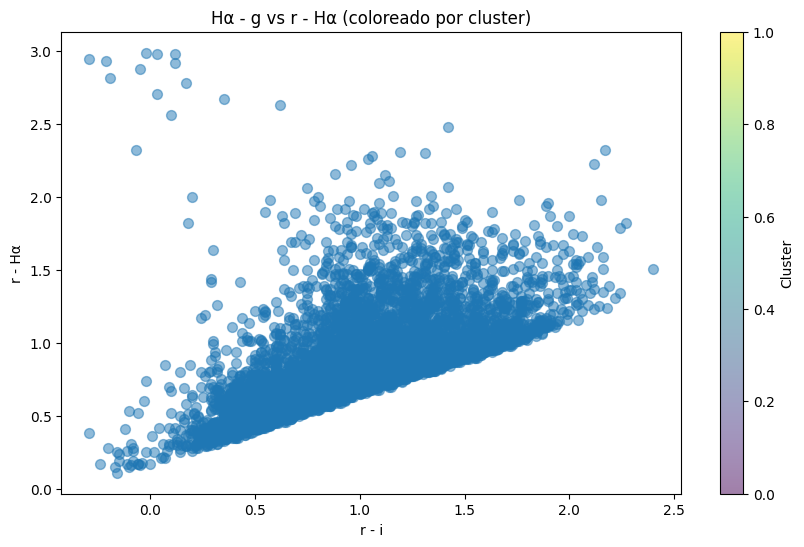

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['r_i'], df_clean['r_Ha'],  cmap='viridis', s=50, alpha=0.5)
plt.xlabel('r - i')
plt.ylabel('r - Hα')
plt.colorbar(label='Cluster')
plt.title('Hα - g vs r - Hα (coloreado por cluster)')
plt.show()

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [15]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, cluster_selection_method='eom')
clusters = clusterer.fit_predict(X_umap)

In [28]:
# Añade clusters al DataFrame
df_clean['cluster'] = clusters

In [42]:
# Agrega RA y DEC desde df_filtered usando los índices de df_clean
df_clean['RA'] = df_filtered.loc[df_clean.index, 'RAJ2000'].values
df_clean['DEC'] = df_filtered.loc[df_clean.index, 'DEJ2000'].values

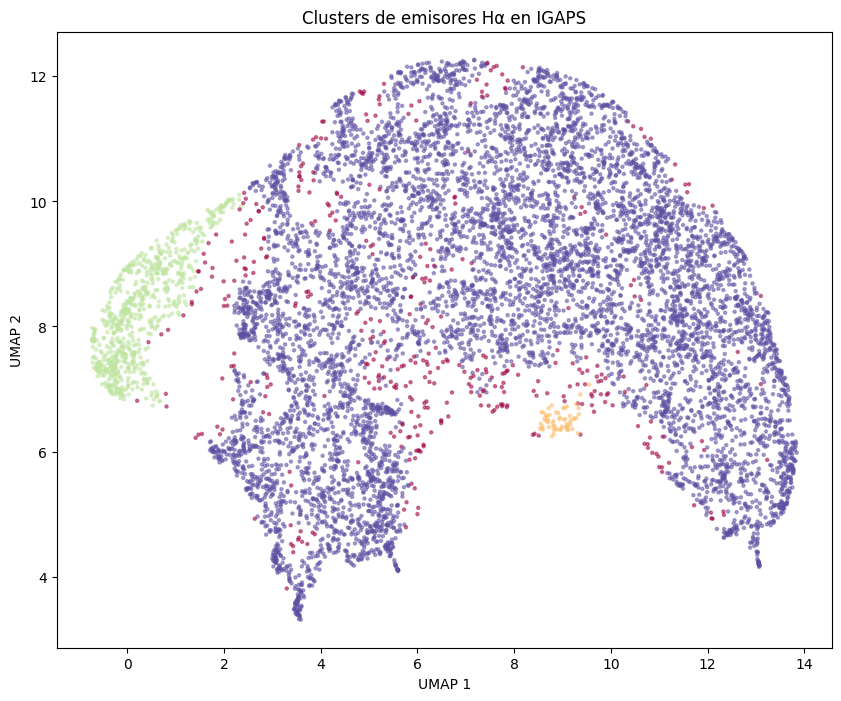

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['cluster'], cmap='Spectral', s=5, alpha=0.5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Clusters de emisores Hα en IGAPS')
plt.show()

<Axes: >

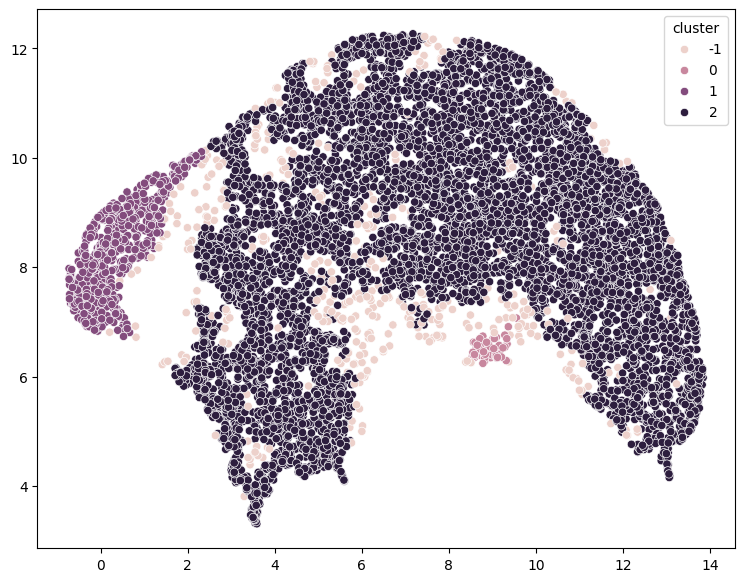

In [44]:
plt.figure(figsize=(9,7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], 
                hue=df_clean['cluster'],
                )


In [45]:
# Group the data based on the "Label" column
grouped_data = df_clean.groupby("cluster")


In [46]:
# Define the directory where you want to save the CSV files
directory = 'Class'

In [47]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_noise.csv'
    else:
        filename = f'Halpha_emitter_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)
